## ⚠️ Proper Evaluation with Train/Test Split

In [2]:
# Proper train/test split evaluation
from matchmaker import MatchingEngine
import cudf
import numpy as np
from tqdm import tqdm

# 1. Load original data and split by timestamp
print("Loading original interaction data...")
raw_data = cudf.read_csv("data/swipes_clean.csv")

# Sort by timestamp and split 80/20
raw_data = raw_data.sort_values('timestamp')
split_idx = int(len(raw_data) * 0.8)

train_data = raw_data.iloc[:split_idx]
test_data = raw_data.iloc[split_idx:]

print(f"Train set: {len(train_data):,} interactions")
print(f"Test set:  {len(test_data):,} interactions")

# Save splits temporarily
train_data.to_csv("/tmp/train_split.csv", index=False)
test_data.to_csv("/tmp/test_split.csv", index=False)

# 2. Build a NEW engine on ONLY the training data
print("\n🔄 Training model on 80% of data...")
engine_test = MatchingEngine()
engine_test.load_interactions("/tmp/train_split.csv",
    decider_col='decidermemberid',
    other_col='othermemberid', 
    like_col='like', 
    timestamp_col='timestamp',
    gender_col='decidergender')
engine_test.run_engagement()
engine_test.run_elo()
engine_test.build_recommender()
print("✅ Training complete on train set")

Loading original interaction data...
Train set: 7,862,310 interactions
Test set:  1,965,578 interactions

🔄 Training model on 80% of data...
Reading data... ✅
Fitting ALS... 
🚀 Preparing data...
🎯 Training male→female ALS...


100%|██████████| 15/15 [00:00<00:00, 20.89it/s]


🎯 Training female→male ALS...


100%|██████████| 15/15 [00:00<00:00, 337.38it/s]


🔄 Converting factors to CuPy arrays...
✅ Trained M2F ALS with 31134 males × 32994 females
✅ Trained F2M ALS with 9925 females × 38446 males
Complete! ✅
User DF updated ✅
User DF updated ✅
Building FAISS recommender... ✅
✅ Training complete on train set


In [6]:
def evaluate_mutual_compatibility(engine_test, test_data, gender='M', k=100):
    """
    Evaluate mutual compatibility on held-out test set.
    
    Parameters:
    -----------
    engine_test : MatchingEngine
        The trained recommendation engine
    test_data : cudf.DataFrame
        Test set interactions
    gender : str
        'M' for males viewing females, 'F' for females viewing males
    k : int
        Number of recommendations to generate per user
        
    Returns:
    --------
    dict : Evaluation results including metrics and recommendations
    """
    from tqdm import tqdm
    import cudf
    
    print(f"\n📊 Evaluating MUTUAL compatibility - {gender} users viewing {'females' if gender=='M' else 'males'}...\n")
    
    # ⚡ KEEP ON GPU: Filter likes on GPU
    test_likes = test_data[test_data['like'] == 1][['decidermemberid', 'othermemberid']]
    
    # ⚡ KEEP ON GPU: Get gender mapping on GPU
    user_genders_df = engine_test.user_df[['user_id', 'gender']].rename(columns={'user_id': 'decidermemberid'})
    
    # ⚡ KEEP ON GPU: Merge to get genders
    test_likes_with_gender = test_likes.merge(user_genders_df, on='decidermemberid', how='left')
    
    # Build gender-specific like dictionaries
    if gender == 'M':
        # Males viewing females
        male_likes = test_likes_with_gender[test_likes_with_gender['gender'] == 'M']
        my_likes = male_likes.groupby('decidermemberid')['othermemberid'].agg(list).to_pandas()
        my_likes = {k: set(v) for k, v in my_likes.items()}
        
        # Females who liked males (for mutual check)
        female_likes = test_likes_with_gender[test_likes_with_gender['gender'] == 'F']
        their_likes = female_likes.groupby('decidermemberid')['othermemberid'].agg(list).to_pandas()
        their_likes = {k: set(v) for k, v in their_likes.items()}
        
        label = "MALES VIEWING FEMALES"
        opposite_label = "female"
    else:
        # Females viewing males
        female_likes = test_likes_with_gender[test_likes_with_gender['gender'] == 'F']
        my_likes = female_likes.groupby('decidermemberid')['othermemberid'].agg(list).to_pandas()
        my_likes = {k: set(v) for k, v in my_likes.items()}
        
        # Males who liked females (for mutual check)
        male_likes = test_likes_with_gender[test_likes_with_gender['gender'] == 'M']
        their_likes = male_likes.groupby('decidermemberid')['othermemberid'].agg(list).to_pandas()
        their_likes = {k: set(v) for k, v in their_likes.items()}
        
        label = "FEMALES VIEWING MALES"
        opposite_label = "male"
    
    # Calculate total mutual matches in test set
    total_mutual_matches_in_test = 0
    for user_id in my_likes:
        for other_id in my_likes[user_id]:
            # Check if mutual
            if user_id in their_likes.get(other_id, set()):
                total_mutual_matches_in_test += 1
    
    # ⚡ KEEP ON GPU: Filter valid users on GPU
    user_df_test = engine_test.user_df
    valid_users_gpu = user_df_test[user_df_test['user_id'].isin(list(my_likes.keys()))]
    test_users_valid = valid_users_gpu['user_id'].to_arrow().to_pylist()
    
    print(f"Test users ({gender}) with held-out likes: {len(test_users_valid):,}")
    print(f"Opposite gender users who liked someone: {len(their_likes):,}")
    print(f"Total mutual matches in test set: {total_mutual_matches_in_test:,}")
    
    if len(test_users_valid) == 0:
        print("⚠️ No test users found")
        return None
    
    # Generate recommendations for ALL users
    print(f"Generating recommendations for all {len(test_users_valid):,} users...")
    recs_batch = engine_test.recommend_batch(test_users_valid, k=k)
    
    hits = 0
    mutual_hits = 0
    all_recs = []
    mutual_matches = []
    
    for user_id in tqdm(test_users_valid, desc=f"Evaluating {gender}"):
        # Extract user IDs from recommendations
        recs = [rec[0] for rec in recs_batch[user_id]]
        all_recs.extend(recs)
        
        # Get who this user liked in test set
        actual_likes = my_likes.get(user_id, set())
        recommended = set(recs)
        
        # One-sided hit (user liked someone we recommended)
        if len(actual_likes & recommended) > 0:
            hits += 1
            
            # Check for MUTUAL compatibility
            for other_id in (actual_likes & recommended):
                # Did the other person ALSO like this user in the test set?
                if user_id in their_likes.get(other_id, set()):
                    mutual_hits += 1
                    mutual_matches.append((user_id, other_id))
                    break  # Count once per user
    
    # Calculate metrics
    hit_rate = hits / len(test_users_valid)
    mutual_hit_rate = mutual_hits / len(test_users_valid)
    personalization = len(set(all_recs)) / len(all_recs) if len(all_recs) > 0 else 0
    recall_of_matches = mutual_hits / total_mutual_matches_in_test if total_mutual_matches_in_test > 0 else 0
    
    print(f"\n{'='*70}")
    print(f"📊 HELD-OUT TEST SET EVALUATION (k={k}) - {label}")
    print(f"{'='*70}")
    print(f"One-Sided Hit Rate:    {hit_rate:.2%} ({hits:,}/{len(test_users_valid):,} users)")
    print(f"   ↳ User liked someone we recommended")
    print(f"\nMUTUAL Match Rate:     {mutual_hit_rate:.2%} ({mutual_hits:,}/{len(test_users_valid):,} users)")
    print(f"   ↳ Both users liked each other (TRUE compatibility!)")
    print(f"\nMatch Recall:          {recall_of_matches:.2%} ({mutual_hits:,}/{total_mutual_matches_in_test:,} matches)")
    print(f"   ↳ Proportion of ALL mutual matches we found in top-{k}")
    print(f"\nPersonalization:       {personalization:.2%}")
    print(f"Unique recs:           {len(set(all_recs)):,}")
    print(f"{'='*70}")
    
    if mutual_hits > 0:
        print(f"\n✅ Found {mutual_hits:,} mutual matches out of {total_mutual_matches_in_test:,} total in test set!")
        print(f"💡 Match recall of {recall_of_matches:.1%} means we found {recall_of_matches:.1%} of all possible matches in top-{k}!")
    
    return {
        'gender': gender,
        'test_users_valid': test_users_valid,
        'all_recs': all_recs,
        'hits': hits,
        'mutual_hits': mutual_hits,
        'mutual_matches': mutual_matches,
        'hit_rate': hit_rate,
        'mutual_hit_rate': mutual_hit_rate,
        'personalization': personalization,
        'total_mutual_matches_in_test': total_mutual_matches_in_test,
        'recall_of_matches': recall_of_matches
    }

In [7]:
def analyse_recommendation_coverage(engine, results_dict, opposite_gender='F'):
    """
    Analyse which users are being recommended and correlate with popularity/engagement.
    
    Parameters:
    -----------
    engine : MatchingEngine
        The trained recommendation engine
    results_dict : dict
        Results from evaluate_mutual_compatibility function
    opposite_gender : str
        'F' to analyse females being recommended (to males)
        'M' to analyse males being recommended (to females)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from collections import Counter
    from scipy.stats import pearsonr, spearmanr
    
    all_recs = results_dict['all_recs']
    test_users_valid = results_dict['test_users_valid']
    
    # Get all potential candidates of specified gender
    user_df_test = engine.user_df
    candidates = user_df_test[user_df_test.gender == opposite_gender].copy().to_pandas()
    
    # Count how many times each candidate was recommended
    rec_counts_dict = Counter(all_recs)
    candidates['times_recommended'] = candidates['user_id'].map(lambda x: rec_counts_dict.get(x, 0))
    
    # Get candidates who were NEVER recommended
    never_recommended = candidates[candidates['times_recommended'] == 0]
    recommended_users = candidates[candidates['times_recommended'] > 0]
    
    gender_label = "Female" if opposite_gender == 'F' else "Male"
    
    print(f"\n📊 RECOMMENDATION COVERAGE ANALYSIS ({gender_label} Users)")
    print(f"{'='*70}")
    print(f"Total {gender_label.lower()} users available: {len(candidates):,}")
    print(f"{gender_label}s recommended at least once: {len(recommended_users):,}")
    print(f"{gender_label}s NEVER recommended: {len(never_recommended):,} ({len(never_recommended)/len(candidates)*100:.1f}%)")
    
    # Check if any users were actually recommended
    if len(recommended_users) == 0:
        print(f"\n⚠️  WARNING: No {gender_label.lower()}s were recommended in this evaluation!")
        return candidates, recommended_users, never_recommended
    
    print(f"{'='*70}\n")
    
    # Create scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Times Recommended vs elo_rating (Popularity)
    axes[0].scatter(candidates['elo_rating'], candidates['times_recommended'], 
                    alpha=0.5, s=20, c=candidates['times_recommended'], cmap='viridis')
    axes[0].set_xlabel('elo_rating Score (Popularity)', fontsize=12)
    axes[0].set_ylabel('Times Recommended', fontsize=12)
    axes[0].set_title(f'{gender_label} Recommendation Frequency vs Popularity Score', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log')
    
    # Add correlation
    valid_mask = ~candidates['elo_rating'].isna() & ~candidates['times_recommended'].isna()
    if valid_mask.sum() > 0:
        pearson_corr, _ = pearsonr(candidates[valid_mask]['elo_rating'], 
                                    candidates[valid_mask]['times_recommended'])
        spearman_corr, _ = spearmanr(candidates[valid_mask]['elo_rating'], 
                                      candidates[valid_mask]['times_recommended'])
        axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr:.3f}\nSpearman: {spearman_corr:.3f}', 
                    transform=axes[0].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. Times Recommended vs Engagement Score
    axes[1].scatter(candidates['engagement_score'], candidates['times_recommended'], 
                    alpha=0.5, s=20, c=candidates['times_recommended'], cmap='plasma')
    axes[1].set_xlabel('Engagement Score', fontsize=12)
    axes[1].set_ylabel('Times Recommended', fontsize=12)
    axes[1].set_title(f'{gender_label} Recommendation Frequency vs Engagement Score', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    # Add correlation
    valid_mask = ~candidates['engagement_score'].isna() & ~candidates['times_recommended'].isna()
    if valid_mask.sum() > 0:
        pearson_corr, _ = pearsonr(candidates[valid_mask]['engagement_score'], 
                                    candidates[valid_mask]['times_recommended'])
        spearman_corr, _ = spearmanr(candidates[valid_mask]['engagement_score'], 
                                      candidates[valid_mask]['times_recommended'])
        axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr:.3f}\nSpearman: {spearman_corr:.3f}', 
                    transform=axes[1].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(f'recommendation_coverage_{opposite_gender}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Detailed stats on never-recommended users
    if len(never_recommended) > 0:
        print(f"\n📉 NEVER-RECOMMENDED {gender_label.upper()}S ANALYSIS:")
        print(f"   • Avg elo_rating: {never_recommended['elo_rating'].mean():.6f} (vs {candidates['elo_rating'].mean():.6f} overall)")
        print(f"   • Avg Engagement: {never_recommended['engagement_score'].mean():.2f} (vs {candidates['engagement_score'].mean():.2f} overall)")
        print(f"   • League distribution:")
        for league in ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']:
            count = len(never_recommended[never_recommended['league'] == league])
            pct = count / len(never_recommended) * 100 if len(never_recommended) > 0 else 0
            print(f"      - {league}: {count} ({pct:.1f}%)")
    
    # Compare recommended vs never-recommended users
    print(f"\n📊 COMPARISON: Recommended vs Never-Recommended {gender_label}s")
    print(f"{'='*70}")
    
    print(f"\n{'Metric':<25} {'Recommended':<20} {'Never Recommended':<20}")
    print(f"{'-'*65}")
    print(f"{'Count':<25} {len(recommended_users):<20} {len(never_recommended):<20}")
    print(f"{'Avg elo_rating':<25} {recommended_users['elo_rating'].mean():<20.6f} {never_recommended['elo_rating'].mean():<20.6f}")
    print(f"{'Median elo_rating':<25} {recommended_users['elo_rating'].median():<20.6f} {never_recommended['elo_rating'].median():<20.6f}")
    print(f"{'Avg Engagement':<25} {recommended_users['engagement_score'].mean():<20.2f} {never_recommended['engagement_score'].mean():<20.2f}")
    print(f"{'Median Engagement':<25} {recommended_users['engagement_score'].median():<20.2f} {never_recommended['engagement_score'].median():<20.2f}")
    
    return candidates, recommended_users, never_recommended

In [8]:
# Evaluate ALL males viewing females (no sampling)
results_males = evaluate_mutual_compatibility(engine_test, test_data, gender='M', k=100)


📊 Evaluating MUTUAL compatibility - M users viewing females...

Test users (M) with held-out likes: 19,123
Opposite gender users who liked someone: 4,725
Total mutual matches in test set: 3,714
Generating recommendations for all 19,123 users...
Test users (M) with held-out likes: 19,123
Opposite gender users who liked someone: 4,725
Total mutual matches in test set: 3,714
Generating recommendations for all 19,123 users...


Evaluating M: 100%|██████████| 19123/19123 [00:00<00:00, 130843.43it/s]




📊 HELD-OUT TEST SET EVALUATION (k=100) - MALES VIEWING FEMALES
One-Sided Hit Rate:    44.03% (8,420/19,123 users)
   ↳ User liked someone we recommended

MUTUAL Match Rate:     0.89% (171/19,123 users)
   ↳ Both users liked each other (TRUE compatibility!)

Match Recall:          4.60% (171/3,714 matches)
   ↳ Proportion of ALL mutual matches we found in top-100

Personalization:       1.47%
Unique recs:           25,104

✅ Found 171 mutual matches out of 3,714 total in test set!
💡 Match recall of 4.6% means we found 4.6% of all possible matches in top-100!


In [ ]:
# Evaluate ALL males viewing females (no sampling)
results_males = evaluate_mutual_compatibility(engine_test, test_data, gender='M', k=100)


📊 Evaluating MUTUAL compatibility - M users viewing females...



Test users (M) with held-out likes: 11090
Opposite gender users who liked someone: 4725


Evaluating M: 100%|██████████| 11090/11090 [00:00<00:00, 62943.88it/s]




📊 HELD-OUT TEST SET EVALUATION (k=100) - MALES VIEWING FEMALES
One-Sided Hit Rate:    34.49% (3825/11090 users)
   ↳ User liked someone we recommended

MUTUAL Match Rate:     0.94% (104/11090 users)
   ↳ Both users liked each other (TRUE compatibility!)

Personalization:       2.75%
Unique recs:           28,868

✅ Found 104 mutual matches in held-out test data!
💡 This means the recommender successfully predicted 0.9% of future mutual likes!


In [10]:
# Evaluate females viewing males
results_females = evaluate_mutual_compatibility(engine_test, test_data, gender='F', k=100)


📊 Evaluating MUTUAL compatibility - F users viewing males...

Test users (F) with held-out likes: 4,725
Opposite gender users who liked someone: 19,123
Total mutual matches in test set: 3,714
Generating recommendations for all 4,725 users...
Test users (F) with held-out likes: 4,725
Opposite gender users who liked someone: 19,123
Total mutual matches in test set: 3,714
Generating recommendations for all 4,725 users...


Evaluating F: 100%|██████████| 4725/4725 [00:00<00:00, 143790.62it/s]


📊 HELD-OUT TEST SET EVALUATION (k=100) - FEMALES VIEWING MALES
One-Sided Hit Rate:    1.63% (77/4,725 users)
   ↳ User liked someone we recommended

MUTUAL Match Rate:     0.68% (32/4,725 users)
   ↳ Both users liked each other (TRUE compatibility!)

Match Recall:          0.86% (32/3,714 matches)
   ↳ Proportion of ALL mutual matches we found in top-100

Personalization:       3.15%
Unique recs:           7,292

✅ Found 32 mutual matches out of 3,714 total in test set!
💡 Match recall of 0.9% means we found 0.9% of all possible matches in top-100!


In [5]:
# Evaluate females viewing males
results_females = evaluate_mutual_compatibility(engine_test, test_data, gender='F', k=100, max_users=20000)


📊 Evaluating MUTUAL compatibility - F users viewing males...

Test users (F) with held-out likes: 4307
Opposite gender users who liked someone: 19123
Test users (F) with held-out likes: 4307
Opposite gender users who liked someone: 19123


Evaluating F: 100%|██████████| 4307/4307 [00:00<00:00, 116306.66it/s]


📊 HELD-OUT TEST SET EVALUATION (k=100) - FEMALES VIEWING MALES
One-Sided Hit Rate:    2.23% (96/4307 users)
   ↳ User liked someone we recommended

MUTUAL Match Rate:     0.81% (35/4307 users)
   ↳ Both users liked each other (TRUE compatibility!)

Personalization:       3.56%
Unique recs:           8,084

✅ Found 35 mutual matches in held-out test data!
💡 This means the recommender successfully predicted 0.8% of future mutual likes!



📊 RECOMMENDATION COVERAGE ANALYSIS (Female Users)
Total female users available: 33,844
Females recommended at least once: 25,104
Females NEVER recommended: 8,740 (25.8%)



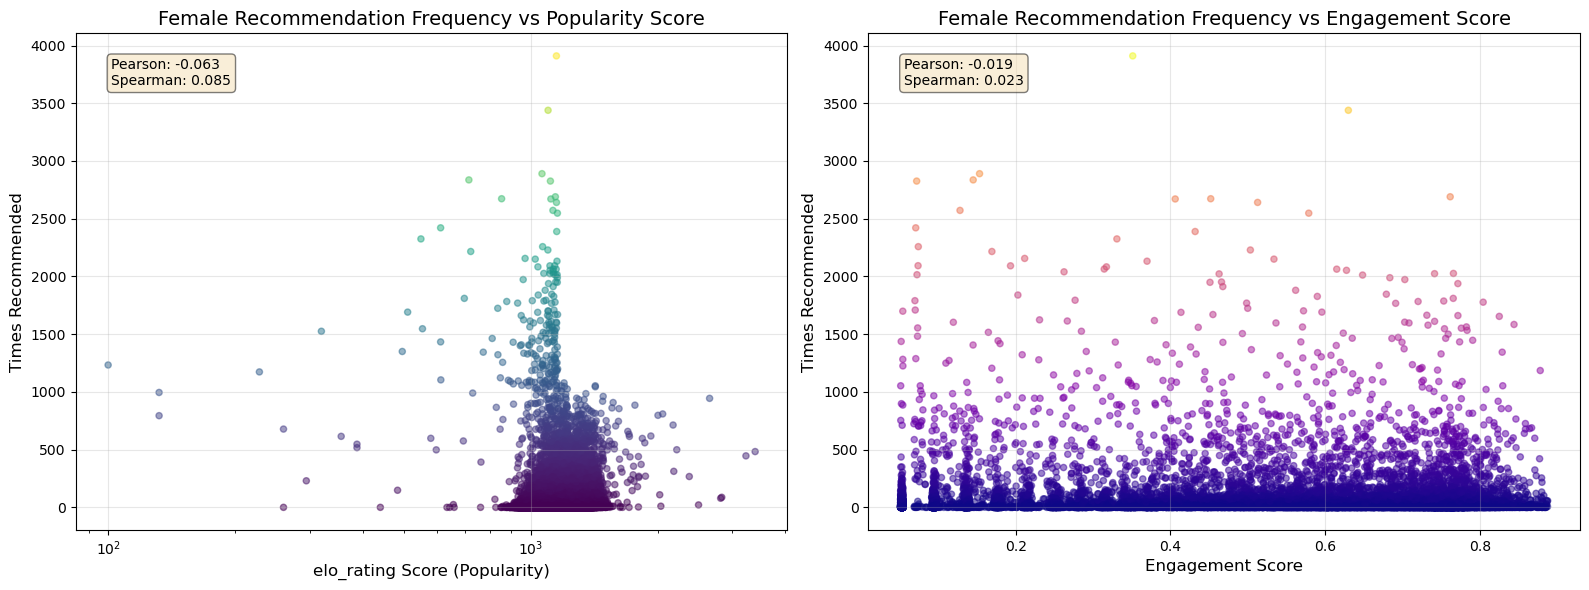


📉 NEVER-RECOMMENDED FEMALES ANALYSIS:
   • Avg elo_rating: 1179.828491 (vs 1213.385742 overall)
   • Avg Engagement: 0.50 (vs 0.51 overall)
   • League distribution:
      - Bronze: 3013 (34.5%)
      - Silver: 1848 (21.1%)
      - Gold: 1486 (17.0%)
      - Platinum: 1258 (14.4%)
      - Diamond: 307 (3.5%)

📊 COMPARISON: Recommended vs Never-Recommended Females

Metric                    Recommended          Never Recommended   
-----------------------------------------------------------------
Count                     25104                8740                
Avg elo_rating            1224.205078          1179.828491         
Median elo_rating         1231.299561          1191.388672         
Avg Engagement            0.52                 0.50                
Median Engagement         0.58                 0.56                


In [11]:
# Analyse females (who were recommended to males)
if results_males:
    analyse_recommendation_coverage(engine_test, results_males, opposite_gender='F')


📊 RECOMMENDATION COVERAGE ANALYSIS (Male Users)
Total male users available: 135,192
Males recommended at least once: 7,292
Males NEVER recommended: 127,900 (94.6%)



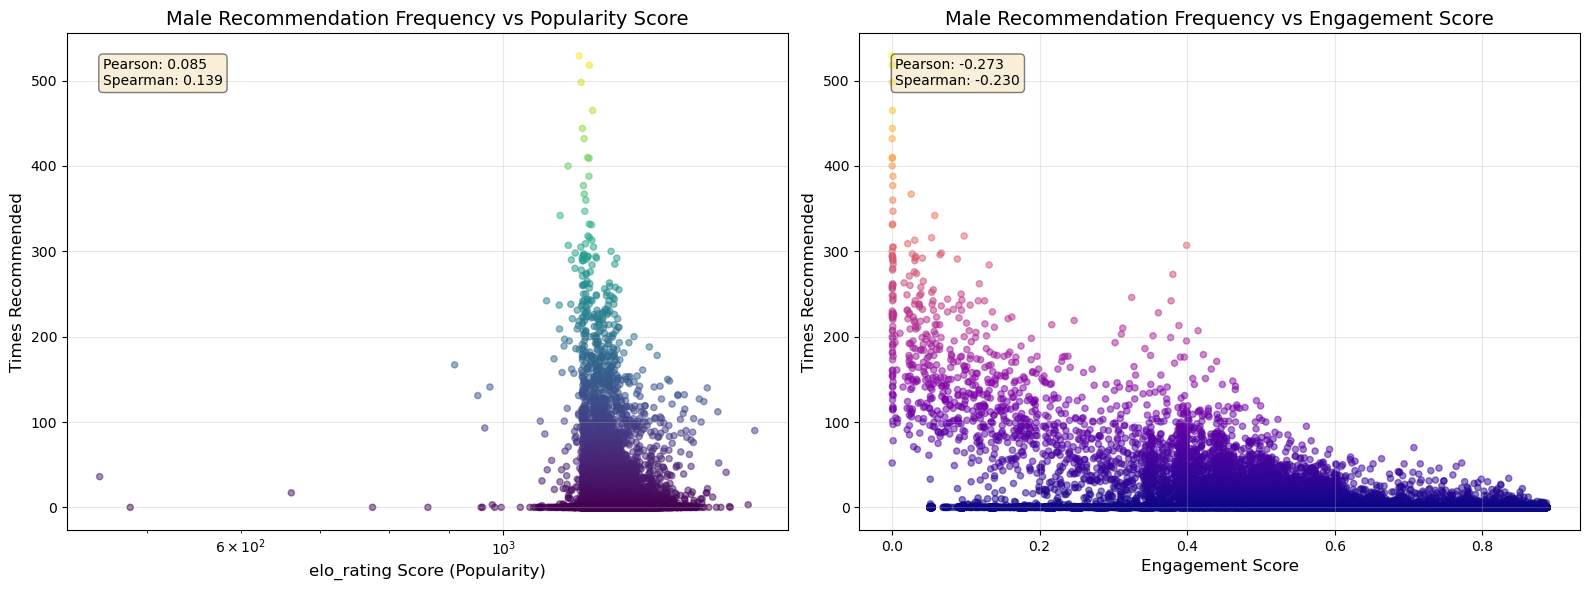


📉 NEVER-RECOMMENDED MALES ANALYSIS:
   • Avg elo_rating: 1196.713257 (vs 1197.962524 overall)
   • Avg Engagement: 0.56 (vs 0.55 overall)
   • League distribution:
      - Bronze: 13546 (10.6%)
      - Silver: 8860 (6.9%)
      - Gold: 8954 (7.0%)
      - Platinum: 8846 (6.9%)
      - Diamond: 3962 (3.1%)

📊 COMPARISON: Recommended vs Never-Recommended Males

Metric                    Recommended          Never Recommended   
-----------------------------------------------------------------
Count                     7292                 127900              
Avg elo_rating            1219.628662          1196.713257         
Median elo_rating         1210.120117          1191.751831         
Avg Engagement            0.48                 0.56                
Median Engagement         0.51                 0.61                


In [12]:
# Analyse males (who were recommended to females)
if results_females:
    analyse_recommendation_coverage(engine_test, results_females, opposite_gender='M')